In [1]:
import sys
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import random_split, DataLoader

In [2]:
#copying pre-process pipeline of ResNet
#source: https://pytorch.org/hub/pytorch_vision_resnet/
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [3]:
# images in folder "D:\msc_dwm_lab_2024\tyre_images"
dataset=torchvision.datasets.ImageFolder(
    root="./tyre_images",
    transform=preprocess
    )

In [4]:
print(dataset.class_to_idx)
print(dataset[0])

{'defective': 0, 'good': 1}
(tensor([[[ 0.0056, -0.0116, -0.0629,  ..., -0.0458, -0.0801, -0.2342],
         [-0.0287, -0.0458, -0.0458,  ..., -0.1143, -0.1657, -0.3541],
         [-0.0116, -0.0287, -0.0629,  ..., -0.1657, -0.1828, -0.3198],
         ...,
         [-0.6794, -1.0048, -0.9705,  ..., -0.6109, -0.6281, -0.6109],
         [-0.7822, -1.0562, -0.8849,  ..., -0.5938, -0.6794, -0.6452],
         [-0.8164, -1.0733, -0.7822,  ..., -0.6281, -0.6109, -0.6109]],

        [[ 0.0826,  0.0651,  0.0126,  ..., -0.1099, -0.1275, -0.2675],
         [ 0.0476,  0.0301,  0.0301,  ..., -0.1625, -0.2150, -0.3901],
         [ 0.0651,  0.0476,  0.0126,  ..., -0.2150, -0.2325, -0.3725],
         ...,
         [-0.7052, -1.0378, -1.0028,  ..., -0.7402, -0.7752, -0.7752],
         [-0.8102, -1.0903, -0.9153,  ..., -0.7402, -0.8277, -0.7927],
         [-0.8452, -1.1078, -0.8102,  ..., -0.7752, -0.7577, -0.7577]],

        [[ 0.2173,  0.1999,  0.1476,  ...,  0.0953,  0.0779, -0.0615],
         [ 0.182

In [5]:
train_ds,val_ds=random_split(dataset,[0.8,0.2])

In [6]:
len(train_ds)

1485

In [7]:
len(val_ds)

371

In [8]:
train_data_loader=DataLoader(train_ds,batch_size=4,shuffle=True)
test_data_loader=DataLoader(val_ds,batch_size=4,shuffle=False)
#check if data has correct shape [batch, channels, height, width]
for X,y in train_data_loader:
    print(X.shape)
    print(y.shape)
    break

torch.Size([4, 3, 224, 224])
torch.Size([4])


In [9]:
device=torch.device("cpu")
if torch.cuda.is_available():
    device=torch.device("cuda")
elif torch.backends.mps.is_available():
    deice=torch.device("mps")

In [10]:
from torch import nn
ResNet50_model =torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
#we need to drop last fully connected layer with definition
#(fc): Linear(in_features=2048, out_features=1000, bias=True)
ResNet50_model.fc=nn.Identity()
#last layer is now over written by Identity layer
for param in ResNet50_model.parameters():
    param.requires_grad=False #no tracking of gradients 
#for speedup processing while training of model
ResNet50_model=ResNet50_model.to(device)
ResNet50_model.eval() #on purpose as we don't want to re-train Resnet model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
#check what's shape of output of model
for X,y in train_data_loader:
    print(ResNet50_model(X).shape)
    print(y.shape)
    break 

torch.Size([4, 2048])
torch.Size([4])


In [ ]:
#Part2: define trainable part of model 
fc_model=nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Linear(1024,1) 
    # output layer with one sigmoidal output
)
fc_model=fc_model.to(device)

In [13]:
#Model ready for Transfer learning
model=nn.Sequential(
    ResNet50_model,
    fc_model
)

In [ ]:
#check what's shape of output of model 
for X,y in train_data_loader:
    print(model(X.to(device)).shape) #send one batch to GPU
    break 
print(y.shape)
print(X.shape)
print(y.dtype)

torch.Size([4, 1])
torch.Size([4])
torch.Size([4, 3, 224, 224])
torch.int64


In [15]:
optimizer=torch.optim.Adam(fc_model.parameters(),lr=0.001)
loss_fn=nn.BCEWithLogitsLoss() #suitable for sigmodal output

In [26]:
#Training steps
for epochs in range(5):
    model.train() # Puts full model in train mode
    ResNet50_model.eval() #Puts ResNet part in eval() mode
    loss_sum=0
    train_acc_sum=0 
    train_count=0
    for X,y in train_data_loader:
        X=X.to(device) #send one batch to GPU
        y=y.to(device).type(torch.float).reshape(-1,1) 
        #reshape(-1,1) brings y in matrix shape from list of numbers
        outputs=model(X)
        optimizer.zero_grad()
        loss=loss_fn(outputs, y)
        loss_sum=loss_sum+loss.item()
        loss.backward()
        optimizer.step()
        predictions=torch.sigmoid(outputs)>0.5
        acc=(predictions==y).sum().item()
        train_acc_sum=train_acc_sum+acc
        train_count=train_count+y.size(0)
    print("Train loss:",loss_sum/len(train_data_loader))
    print("Train Acc:",train_acc_sum/train_count)
    break #remove it for training more than one batch/epoch
    

Train loss: 0.001357482179171594
Train Acc: 1.0


In [ ]:
#Performance on Test data 
model.eval()
test_loss_sum=0
test_acc_sum=0
test_count=0
with torch.no_grad():
    for X,y in test_data_loader:
        X=X.to(device) #send one batch to GPU
        y=y.to(device).type(torch.float).reshape(-1,1) 
        #bring y in matrix shape from list of numbers
        outputs=model(X)
        optimizer.zero_grad()
        loss=loss_fn(outputs, y)
        test_loss_sum=test_loss_sum+loss.item()
        predictions=torch.sigmoid(outputs)>0.5
        acc=(predictions==y).sum().item()
        test_acc_sum=test_acc_sum+acc
        test_count=test_count+y.size(0)
        break
    print("Test loss:",test_loss_sum/len(test_data_loader))
    print("Test Acc total:",test_acc_sum)
    print("Test Acc:",test_acc_sum/test_count)

Test loss: 1.325996137932644e-07
Test Acc total: 4
Test Acc: 1.0


In [27]:
#Data Augmentation
from PIL import Image
image=Image.open("tyre_images\good\good (9).jpg")

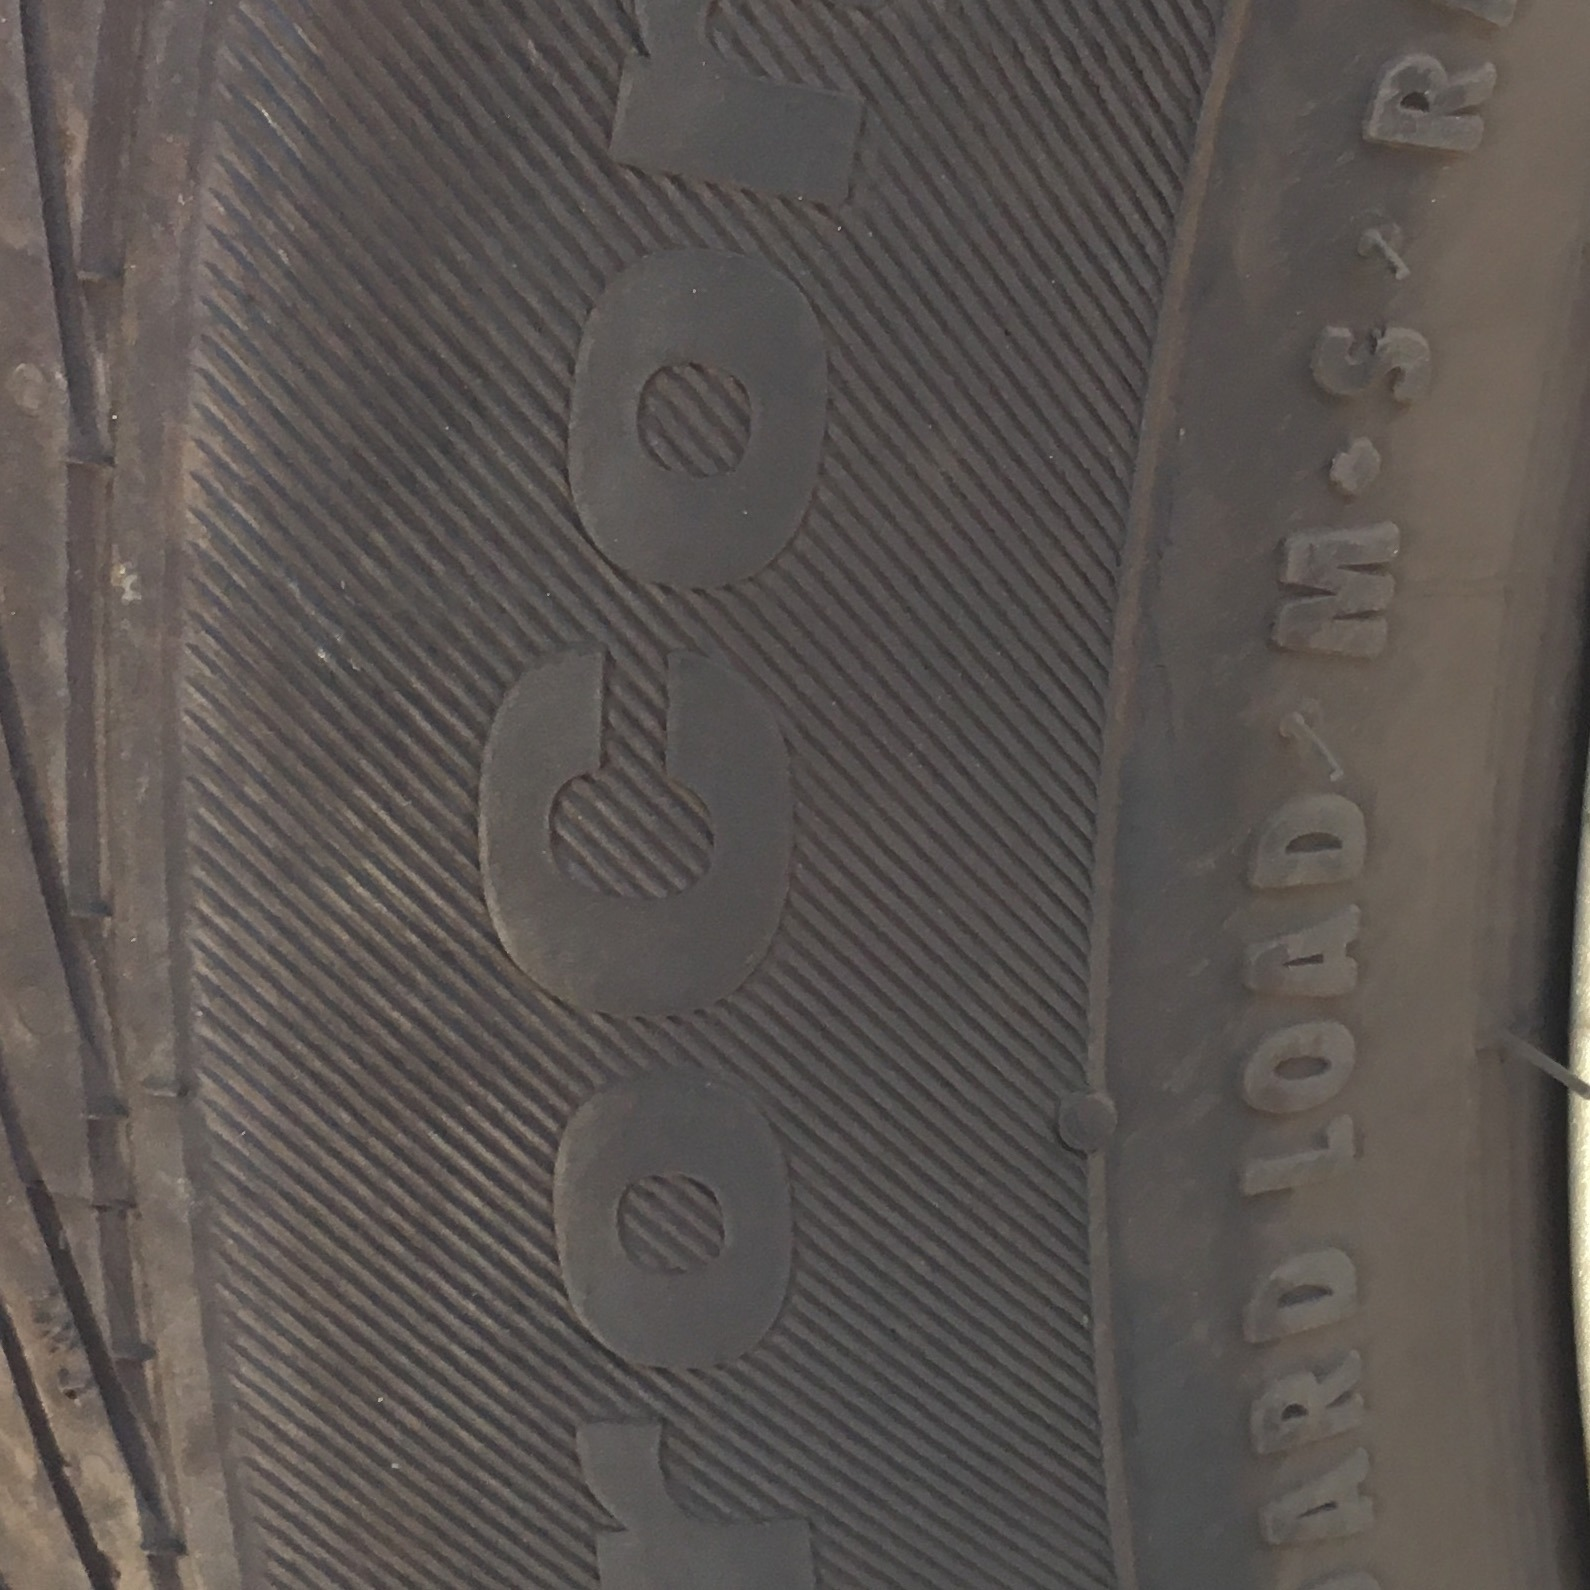

In [28]:
image

In [ ]:
preprocess2 = transforms.Compose([
    transforms.Resize(512),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.1,hue=0.3),
    transforms.Resize(256),
    transforms.CenterCrop(224),
])

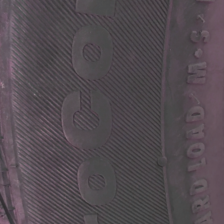

In [38]:
preprocess2(image)

Using tqdm for showing progress bar of training/evaluation 

In [39]:
from tqdm import tqdm

In [ ]:
#Training steps with tqdm & Checkpointing
for epoch in range(5):
    print(f"--------------epoch: {epoch}---------- ")
    model.train() # Puts full model in train mode
    ResNet50_model.eval() #Puts ResNet part in eval() mode
    loss_sum=0
    train_acc_sum=0 
    train_count=0
    for X,y in tqdm(train_data_loader):
        X=X.to(device) #send one batch to GPU
        y=y.to(device).type(torch.float).reshape(-1,1) 
        #reshape(-1,1) brings y in matrix shape from list of numbers
        outputs=model(X)
        optimizer.zero_grad()
        loss=loss_fn(outputs, y)
        loss_sum=loss_sum+loss.item()
        loss.backward()
        optimizer.step()
        predictions=torch.sigmoid(outputs)>0.5 
        acc=(predictions==y).sum().item()
        train_acc_sum=train_acc_sum+acc
        train_count=train_count+y.size(0)
    print("Train loss:",loss_sum/len(train_data_loader))
    print("Train Acc:",train_acc_sum/train_count)
    torch.save(fc_model.state_dict(),f"fc_model_{epoch}.pth")
    break #remove it for training more than one batch/epoch   

--------------epoch: 0---------- 


100%|██████████| 372/372 [03:10<00:00,  1.95it/s]


Train loss: 0.0003523925661901017
Train Acc: 1.0


In [42]:
#Performance on Test data with tqdm
model.eval()
test_loss_sum=0
test_acc_sum=0
test_count=0
with torch.no_grad():
    for X,y in tqdm(test_data_loader):
        X=X.to(device) #send one batch to GPU
        y=y.to(device).type(torch.float).reshape(-1,1) 
        #bring y in matrix shape from list of numbers
        outputs=model(X)
        optimizer.zero_grad()
        loss=loss_fn(outputs, y)
        test_loss_sum=test_loss_sum+loss.item()
        predictions=torch.sigmoid(outputs)>0.5
        acc=(predictions==y).sum().item()
        test_acc_sum=test_acc_sum+acc
        test_count=test_count+y.size(0)
        break
    print("Test loss:",test_loss_sum/len(test_data_loader))
    print("Test Acc total:",test_acc_sum)
    print("Test Acc:",test_acc_sum/test_count)

  0%|          | 0/93 [00:01<?, ?it/s]

Test loss: 1.3825299863118969e-08
Test Acc total: 4
Test Acc: 1.0
